In [11]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import geometric_transform
global fps

from skimage.measure import block_reduce
fps = 20.

global origin
global origin_init
global v0,v1,h0,h1

origin_init = (312,220) ## approximate centroid of video frame
origin = origin_init ## to be updated later

In [2]:
train_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.mp4'
labels_file = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.txt'
test_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/test.mp4'

In [3]:
## Parse labels file
file = open(labels_file, 'r') 
labels = file.read().split()
file.close()
labels = np.asarray(labels).astype('float32')

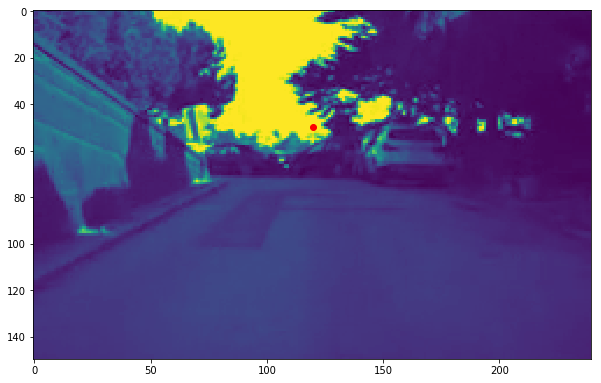

In [4]:
## Try loading a few fraes and mark the origin
vid = imageio.get_reader(test_vid,  'ffmpeg')

v0 = origin_init[0] - 120
v1 = origin_init[0] + 120
h0 = origin_init[1] - 50
h1 = origin_init[1] + 100
origin = (120,50)

vid_frames = []
for num in [300]:
    image = vid.get_data(num)
    vid_frames.append(image[h0:h1,v0:v1])

im = vid_frames[0][:,:,1]

plt.figure(figsize = (10,10))
plt.imshow(vid_frames[0][:,:,1])

plt.plot(origin[0],origin[1],'ro')

## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
#print(v)

In [5]:
## More standard code - computes optical flow based on the Farneback method - 
## modified to avoid converting back to rgb
def opticalFlowFarneback(image_current, image_next,win_size = 5):    
    flow_im = np.zeros((image_current.shape[0],image_current.shape[1],2))
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(image_current, image_next,  
                                        flow_mat, image_scale, 
                                        nb_images, win_size, 
                                        nb_iterations, deg_expansion, 
                                        STD, 0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    flow_im[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    flow_im[:,:,1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_im = np.asarray(flow_im, dtype= np.float32)
    return flow_im.astype('uint8')

## Section 1a preproc data and concatenate the data into training and dev sets

In [6]:
## Preproc data
def preproc_video_frame(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def get_opflow(fr0, fr1, fr2):
    #raw_diff = (fr1-fr0)**0.5
    dat = np.zeros((fr0.shape[0],fr0.shape[1],3))
    flow = opticalFlowFarneback(fr1,fr2,win_size = 2)
    flow2  = opticalFlowFarneback(fr1,fr0,win_size = 2)
    #dat[:,:,0] = fr1 # Option to remove the angle information#flow[:,:,0]
    dat[:,:,0] = flow[:,:,0] # Option to remove the angle information#

    dat[:,:,1] = flow[:,:,1]**0.5
    acc = flow2-flow
    dat[:,:,2] = acc[:,:,1]
    return dat

import time

(1) Load in video while splitting into train and dev set with 5 sec intervals

In [13]:
np.random.seed(2)
def preproc_and_save_im(vid, path,fr, i_save, imAp, imApp):
    return
    image = vid.get_data(fr)[h0:h1,v0:v1]
    imA = preproc_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
        
    datA = block_reduce(datA, block_size=(3, 3, 1), func=np.median)
                
    fle_name = path+'Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)

    
def proc_3boost(vid, path,fr, i_save, imAp, imApp):
    vidframes_train_A = []
    vidframes_train_B = []
    vidframes_train_C = []
                               
    ## initialize prev values at the start of a segment
    image = vid.get_data(ind_frames[0])[h0:h1,v0:v1]
    imApp, imBpp, imCpp = preproc_video_frame(image)
    image = vid.get_data(ind_frames[1])[h0:h1,v0:v1]
    imAp, imBp, imCp = preproc_video_frame(image)

    for fr in ind_frames[2:]:
        image = vid.get_data(fr)[h0:h1,v0:v1]
        imA,imB,imC = preproc_video_frame_3(image)
        datA = get_opflow(imA, imAp, imApp)
        datB = get_opflow(imB, imBp, imBpp)
        datC = get_opflow(imC, imCp, imCpp)

        vidframes_train_A.append(datA)
        vidframes_train_B.append(datB)
        vidframes_train_C.append(datC)

        ## update timesteps from op flow calculations
        imApp, imBpp, imCpp = imAp, imBp, imCp
        imAp, imBp, imCp = imA,imB,imC

    ## Save the images to folder called train
    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_A[0])
    i_save += 1    
    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_A[0])
    i_save += 1
    for n in range(len(vidframes_train_A)):
        fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
        cv2.imwrite(fle_name, vidframes_train_A[n])
        i_save += 1

    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_B[0])
    i_save += 1
    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_B[0])
    i_save += 1
    for n in range(len(vidframes_train_B)):
        fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
        cv2.imwrite(fle_name, vidframes_train_B[n])
        i_save += 1
    
    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_C[0])
    i_save += 1
    fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, vidframes_train_C[0])
    i_save += 1
    for n in range(len(vidframes_train_C)):
        fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/Im'+str(i_save)+'.png'
        cv2.imwrite(fle_name, vidframes_train_C[n])
        i_save += 1
        
    
    for i in range(3):
        labels_train.append(labels[ind_frames)
        t_train.append(ind_frames/fps)
                                   

def split_Nsec_intervals(labels, Nsec, maxFrames = None):
    ## Select random sets of n sec: 80% train set, 20% dev set
    
    vid = imageio.get_reader(train_vid,  'ffmpeg')
    train_path = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train_simple/'
    dev_path = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/'
    
    if maxFrames == None:
        maxFrames = len(labels)
    
    Nframes = int(Nsec*fps)
    L = maxFrames
    L = L-np.mod(L,Nframes)
    i_split = np.random.rand(int(L/Nframes)) 
    A = np.percentile(i_split,80)
    i_split = i_split < A

    
    vidframes_train = []
    vidframes_dev = []
    labels_train = []
    labels_dev = []
    t_train = []
    t_dev = []
    i_save = 0
    i_save_d = 0
    tic = time.time()
    
    for i,ix in enumerate(i_split):
        toc = time.time()-tic
        print('Processing %d of %d   time: %.1f sec'%(i,len(i_split),toc))
        tic = time.time()
        
        ind_frames = np.arange(i*Nframes,(i+1)*Nframes,1)
        
        if ix: ## for train set
                                                              
            ## initialize prev values at the start of a segment
            image = vid.get_data(ind_frames[0])[h0:h1,v0:v1]
            imApp = preproc_video_frame(image)
            image = vid.get_data(ind_frames[1])[h0:h1,v0:v1]
            imAp = preproc_video_frame(image)
            
            ## Extend image 2 into frames 0 and 2
            image = vid.get_data(2)[h0:h1,v0:v1]
            imA = preproc_video_frame(image)
            datA = get_opflow(imA, imAp, imApp)     
            datA = block_reduce(datA, block_size=(5, 5, 1), func=np.max)
            fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train_simple/Im'+str(i_save)+'.png'
            cv2.imwrite(fle_name, datA)
            i_save += 1
            fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train_simple/Im'+str(i_save)+'.png'
            cv2.imwrite(fle_name, datA)
            i_save += 1
            
            for fr in ind_frames[2:]:
                
                preproc_and_save_im(vid,train_path, fr, i_save, imAp, imApp)
                
                ## update timesteps from op flow calculations
                i_save += 1
                imApp  = imAp
                imAp = imA 
                
            labels_train.append(labels[ind_frames])
            t_train.append(ind_frames/fps)

        
        else: ## for dev set
            image = vid.get_data(ind_frames[0])[h0:h1,v0:v1]
            imApp = preproc_video_frame(image)
            image = vid.get_data(ind_frames[1])[h0:h1,v0:v1]
            imAp = preproc_video_frame(image)
            
            ## Extend image 2 into frames 0 and 2
            image = vid.get_data(2)[h0:h1,v0:v1]
            imA = preproc_video_frame(image)
            datA = get_opflow(imA, imAp, imApp)     
            datA = block_reduce(datA, block_size=(5, 5, 1), func=np.max)
            fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/Im'+str(i_save_d)+'.png'
            cv2.imwrite(fle_name, datA)
            i_save_d += 1
            fle_name = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/Im'+str(i_save_d)+'.png'
            cv2.imwrite(fle_name, datA)
            i_save_d += 1
            
            for fr in ind_frames[2:]:

                preproc_and_save_im(vid, dev_path, fr, i_save_d, imAp, imApp)

        
                ## update timesteps from op flow calculations
                i_save_d += 1
                imApp = imAp.copy()
                imAp = imA.copy()
                
            labels_dev.append(labels[ind_frames])
            t_dev.append(ind_frames/fps)
            
#            print('Values should be equal: %d %d'%(len(np.asarray(labels_dev).astype('float32').ravel()),i_save_d))
                
    labels_train = np.asarray(labels_train).astype('float32').ravel()
    labels_dev = np.asarray(labels_dev).astype('float32').ravel()
    t_train = np.asarray(t_train).astype('float32').ravel()
    t_dev = np.asarray(t_dev).astype('float32').ravel()
    
    print(i_save)
    print(i_save_d)
    return labels_train,labels_dev,t_train,t_dev

labels_train,labels_dev,t_train,t_dev = split_Nsec_intervals(labels,Nsec = 5)#, maxFrames = 10000)
print('Training labels: %d  Dev labels: %d'%(len(labels_train),len(labels_dev)))
              
with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_dev.txt', 'w') as f:
    for item in labels_dev:
        f.write("%s\n" % item)

with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_dev.txt', 'w') as f:
    for item in t_dev:
        f.write("%s\n" % item)
        
with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_train.txt', 'w') as f:
    for item in labels_train:
        f.write("%s\n" % item)

with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_train.txt', 'w') as f:
    for item in t_train:
        f.write("%s\n" % item)

Processing 0 of 204   time: 0.0 sec
Processing 1 of 204   time: 0.0 sec
Processing 2 of 204   time: 0.3 sec
Processing 3 of 204   time: 0.4 sec
Processing 4 of 204   time: 0.2 sec
Processing 5 of 204   time: 0.3 sec
Processing 6 of 204   time: 0.4 sec
Processing 7 of 204   time: 0.3 sec
Processing 8 of 204   time: 0.4 sec
Processing 9 of 204   time: 0.2 sec
Processing 10 of 204   time: 0.3 sec
Processing 11 of 204   time: 0.5 sec
Processing 12 of 204   time: 0.3 sec
Processing 13 of 204   time: 0.4 sec
Processing 14 of 204   time: 0.2 sec
Processing 15 of 204   time: 0.3 sec
Processing 16 of 204   time: 0.4 sec
Processing 17 of 204   time: 0.3 sec
Processing 18 of 204   time: 0.4 sec
Processing 19 of 204   time: 0.2 sec
Processing 20 of 204   time: 0.3 sec
Processing 21 of 204   time: 0.5 sec
Processing 22 of 204   time: 0.2 sec
Processing 23 of 204   time: 0.4 sec
Processing 24 of 204   time: 0.2 sec
Processing 25 of 204   time: 0.3 sec
Processing 26 of 204   time: 0.5 sec
Processing 

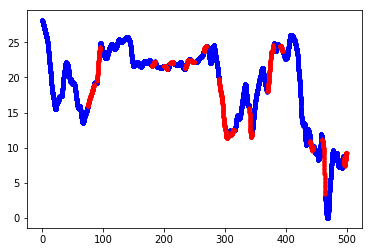

In [379]:
## Visualise speeds in the training and dev sets
plt.figure()
plt.plot(t_train,labels_train,'b.')
plt.plot(t_dev,labels_dev,'r.')

## Process the test video

In [49]:
def preproc_test_vid():    
    
    test_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/test.mp4'
    vid = imageio.get_reader(test_vid,  'ffmpeg')
    
    test_path = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test/'
    
    maxFrames = 10798

    vidframes_test = []
    i_save = 0
    
    image = vid.get_data(0)[h0:h1,v0:v1]
    imApp = preproc_video_frame(image)
    image = vid.get_data(1)[h0:h1,v0:v1]
    imAp = preproc_video_frame(image)
    
    ## Extend image 2 into frames 0 and 2
    image = vid.get_data(2)[h0:h1,v0:v1]
    imA = preproc_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
    datA = block_reduce(datA, block_size=(5, 5, 1), func=np.max)
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
            
    tic = time.time()
    
    for fr in np.arange(2,maxFrames,1):
        preproc_and_save_im(vid, test_path ,fr, i_save, imAp, imApp)

        i_save += 1
        
        ## update timesteps from op flow calculations
        imApp = imAp.copy()
        imAp = imA.copy()
        
        if np.mod(fr,1000)==0:
            t = time.time()-tic
            print('Processed %d of %d Step time %.2f sec'%(fr,maxFrames,t))
            tic = time.time()

preproc_test_vid()

Processed 1000 of 10798 Step time 25.03 sec
Processed 2000 of 10798 Step time 24.42 sec
Processed 3000 of 10798 Step time 26.16 sec
Processed 4000 of 10798 Step time 26.11 sec
Processed 5000 of 10798 Step time 23.81 sec
Processed 6000 of 10798 Step time 27.61 sec
Processed 7000 of 10798 Step time 28.00 sec
Processed 8000 of 10798 Step time 24.63 sec
Processed 9000 of 10798 Step time 22.64 sec
Processed 10000 of 10798 Step time 23.53 sec


In [42]:
from skimage.measure import block_reduce
train_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/'
dev_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/'
test_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test/'

train_data_out = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train_small/'
dev_data_out = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev_small/'
test_data_out = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test_small/'


N_train_samples = 47922
N_dev_samples = 4018
N_test_samples = 10798


def reduce_image_size(dir_in,dir_out,N_im):
    ## Load train images from directory
    i_file = 0
    tic = time.time()
    
    for f in range(N_im):
        file = dir_in + 'Im'+str(i_file) + '.png'
        im = cv2.imread(file)
        im = block_reduce(im, block_size=(5, 5, 1), func=np.mean)        
        fle_name = dir_out + 'Im'+str(i_file)+'.png'
        cv2.imwrite(fle_name, im)        
        i_file+=1
        
        if np.mod(f,1000)==0:
            t = time.time()-tic
            print('Processed %d of %d Step time %.2f sec'%(f,N_im,t))
            tic = time.time()

    
reduce_image_size(test_data_dir,test_data_out,N_test_samples)

Processed 0 of 10798 Step time 0.01 sec
Processed 1000 of 10798 Step time 4.25 sec
Processed 2000 of 10798 Step time 4.22 sec
Processed 3000 of 10798 Step time 4.46 sec
Processed 4000 of 10798 Step time 4.26 sec
Processed 5000 of 10798 Step time 4.33 sec
Processed 6000 of 10798 Step time 4.45 sec
Processed 7000 of 10798 Step time 4.27 sec
Processed 8000 of 10798 Step time 4.34 sec
Processed 9000 of 10798 Step time 4.34 sec
Processed 10000 of 10798 Step time 4.46 sec


AttributeError: 'NoneType' object has no attribute 'ndim'